In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sns.set()

# Data processing

In [2]:
pd.set_option("max_columns", 300)

In [3]:
train = pd.read_csv("data/raw/application_train.csv")
test = pd.read_csv("data/raw/application_test.csv")

In [4]:
fl_col = [var for var in train.columns if "FLAG" in var]

In [5]:
fl_col = [var for var in train.columns if "FLAG" in var]

train[fl_col] = train[fl_col].agg([lambda x: True if x == "Y" else False])
test[fl_col] = test[fl_col].agg([lambda x: True if x == "Y" else False])

In [6]:
train["AMT_ANNUITY"].fillna(train["AMT_INCOME_TOTAL"] * 0.2,inplace=True)
test["AMT_ANNUITY"].fillna(test["AMT_INCOME_TOTAL"] * 0.2,inplace=True)

In [7]:
train['CREDIT_SUB_GOODP'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']

In [8]:
train[['CREDIT_SUB_GOODP',"TARGET"]][train['CREDIT_SUB_GOODP'] > 0].mean()

CREDIT_SUB_GOODP    179048.076923
TARGET                   0.050000
dtype: float64

In [9]:
train['CREDIT_REL_SIZE'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_DIV_INCOME'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['PAY_YEARS'] = train['AMT_CREDIT'] / train['AMT_ANNUITY'] # pay years
train['CREDIT_SUB_GOODP'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
train['CAR_EXPENSES'] = train['FLAG_OWN_CAR'] * 5_000
train['FREE_MONEY'] = train['AMT_INCOME_TOTAL'] - train['CAR_EXPENSES'] - train['AMT_ANNUITY']

In [10]:
test['CREDIT_REL_SIZE'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_DIV_INCOME'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['PAY_YEARS'] = test['AMT_CREDIT'] / test['AMT_ANNUITY'] # pay years
test['CREDIT_SUB_GOODP'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
test['CAR_EXPENSES'] = test['FLAG_OWN_CAR'] * 5_000 
test['FREE_MONEY'] = test['AMT_INCOME_TOTAL'] - test['CAR_EXPENSES'] - test['AMT_ANNUITY']

In [11]:
car_age_median = train["OWN_CAR_AGE"].median()

train["OWN_CAR_AGE"].fillna(car_age_median, inplace=True)
test["OWN_CAR_AGE"].fillna(car_age_median, inplace=True)

ext1_median = train["EXT_SOURCE_1"].median()
ext2_median = train["EXT_SOURCE_2"].median()
ext3_median = train["EXT_SOURCE_3"].median()

train["EXT_SOURCE_1"].fillna(ext1_median, inplace=True)
train["EXT_SOURCE_2"].fillna(ext2_median, inplace=True)
train["EXT_SOURCE_3"].fillna(ext3_median, inplace=True)

test["EXT_SOURCE_1"].fillna(ext1_median, inplace=True)
test["EXT_SOURCE_2"].fillna(ext2_median, inplace=True)
test["EXT_SOURCE_3"].fillna(ext3_median, inplace=True)

In [12]:
train['CREDIT_SUB_GOODP'].fillna(train['CREDIT_SUB_GOODP'].median(), inplace=True)
test['CREDIT_SUB_GOODP'].fillna(train['CREDIT_SUB_GOODP'].median(), inplace=True)

In [13]:
def standartization(df, col, mn, st):
    df[col] = (df[col] - mn) / st
    
    return df

col_mean = train['CREDIT_REL_SIZE'].mean()
col_std = train['CREDIT_REL_SIZE'].std()
train = standartization(train, 'CREDIT_REL_SIZE', col_mean, col_std)
test = standartization(test, 'CREDIT_REL_SIZE', col_mean, col_std)

col_mean = train['ANNUITY_DIV_INCOME'].mean()
col_std = train['ANNUITY_DIV_INCOME'].std()
train = standartization(train, 'ANNUITY_DIV_INCOME', col_mean, col_std)
test = standartization(test, 'ANNUITY_DIV_INCOME', col_mean, col_std)

col_mean = train['PAY_YEARS'].mean()
col_std = train['PAY_YEARS'].std()
train = standartization(train, 'PAY_YEARS', col_mean, col_std)
test = standartization(test, 'PAY_YEARS', col_mean, col_std)

col_mean = train['FREE_MONEY'].mean()
col_std = train['FREE_MONEY'].std()
train = standartization(train, 'FREE_MONEY', col_mean, col_std)
test = standartization(test, 'FREE_MONEY', col_mean, col_std)

col_mean = train['DAYS_EMPLOYED'].mean()
col_std = train['DAYS_EMPLOYED'].std()
train = standartization(train, 'DAYS_EMPLOYED', col_mean, col_std)
test = standartization(test, 'DAYS_EMPLOYED', col_mean, col_std)

col_mean = train['DAYS_REGISTRATION'].mean()
col_std = train['DAYS_REGISTRATION'].std()
train = standartization(train, 'DAYS_REGISTRATION', col_mean, col_std)
test = standartization(test, 'DAYS_REGISTRATION', col_mean, col_std)

col_mean = train['OWN_CAR_AGE'].mean()
col_std = train['OWN_CAR_AGE'].std()
train = standartization(train, 'OWN_CAR_AGE', col_mean, col_std)
test = standartization(test, 'OWN_CAR_AGE', col_mean, col_std)


col_mean = train['CREDIT_SUB_GOODP'].mean()
col_std = train['CREDIT_SUB_GOODP'].std()
train = standartization(train, 'CREDIT_SUB_GOODP', col_mean, col_std)
test = standartization(test, 'CREDIT_SUB_GOODP', col_mean, col_std)

In [14]:
x_cols = ['CREDIT_REL_SIZE', 'ANNUITY_DIV_INCOME', 'PAY_YEARS', 'FREE_MONEY','DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','CREDIT_SUB_GOODP']

# Catboost

In [20]:
from catboost import CatBoostRegressor, CatBoostClassifier, metrics
from scipy import stats
from catboost import Pool
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss

In [23]:
def crossValidation(df, x_col, y_col, cvModel, debag=False, **kwargs):
    logList = []
    aucList = []
    i = 1

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(df):
        train_part = df.loc[train_idx, :]
        val_part = df.loc[val_idx, :]

        model = cvModel(random_state=i, **kwargs)
        model.fit(X=train_part[x_col], y=train_part[y_col])
        val_pred = model.predict_proba(val_part[x_col])

        logloss_val = log_loss(val_part[y_col], val_pred)
        auc_val = roc_auc_score(val_part[y_col], val_pred[:, 1])

        logList.append(logloss_val)
        aucList.append(auc_val)

        if not debag:
            print(f'Fold: {i}, AUC: {auc_val}, LOSS: {logloss_val}')
        i += 1
    if not debag:
        print(f'AV_AUC: {np.mean(aucList)}, AV_LOGLOSS: {np.mean(logList)}')

    return np.mean(aucList)

### 0) Подбор параметров по отдельности

Первый параметр (learning_rate)

In [ ]:
cvLearningRates = []

for iterated_value in [0.2, 0.4, 0.6, 0.8, 1.0]:
    cvLearningRates.append(crossValidation(train, x_cols, 'TARGET', CatBoostClassifier,
                            iterations=100, learning_rate=iterated_value, depth=5, l2_leaf_reg=1))
    
    classifier = CatBoostClassifier(loss_function=metrics.Logloss(), random_state=42,
                            iterations=100, learning_rate=iterated_value, depth=5, l2_leaf_reg=1)
    y_score = classifier.fit(train[x_cols], train["TARGET"]).predict_proba(test[x_cols])
    sub = pd.read_csv("data/raw/sample_submission.csv")
    sub['TARGET'] = y_score[:, 1]
    sub.to_csv(f"prediction_catboost_lr_{iterated_value}.csv", index=False)

-> 99: learn: 0.2395527 total: 910 ms remaining: 0us

Второй параметр (depth)

In [ ]:
cvDepths = []
for iterated_value in [5, 6, 7, 8, 9]:
    cvDepths.append(crossValidation(train, x_cols, 'TARGET', CatBoostClassifier,
                            iterations=100, learning_rate=0.2, depth=iterated_value, l2_leaf_reg=1))
    
    classifier = CatBoostClassifier(random_state=42,
                            iterations=100, learning_rate=0.2, depth=iterated_value, l2_leaf_reg=1)
    y_score = classifier.fit(train[x_cols], train["TARGET"]).predict_proba(test[x_cols])
    sub = pd.read_csv("data/raw/sample_submission.csv")
    sub['TARGET'] = y_score[:, 1]
    sub.to_csv(f"prediction_catboost_dp_{iterated_value}.csv", index=False)

-> 99: learn 0.2386567 total: 1.9s remaining: 0us

Третий параметр (l2-leaf-reg)

In [ ]:
cvL2s = []
for iterated_value in [1, 2, 3, 4, 5]:
    cvL2s.append(crossValidation(train, x_cols, 'TARGET', CatBoostClassifier,
                            iterations=100, learning_rate=0.2, depth=5, l2_leaf_reg=iterated_value))
    
    classifier = CatBoostClassifier(random_state=42,
                            iterations=100, learning_rate=0.2, depth=5, l2_leaf_reg=iterated_value)
    y_score = classifier.fit(train[x_cols], train["TARGET"]).predict_proba(test[x_cols])
    sub = pd.read_csv("data/raw/sample_submission.csv")
    sub['TARGET'] = y_score[:, 1]
    sub.to_csv(f"prediction_catboost_l2_{iterated_value}.csv", index=False)

-> 99: learn: 0.2460841 total: 876ms remaining: 0us

Submission results

In [35]:
subLearningRates = [0.75264,0.75342,0.75703,0.74988,0.74806]

In [36]:
subDepths = [0.75264,0.75554,0.75683,0.75503,0.75399]

In [37]:
subL2s = [0.75264,0.75366,0.75406,0.75248, 0.75465]

### Plotting

learning_rate:

Text(0.5, 1.0, 'Обучение рейт')

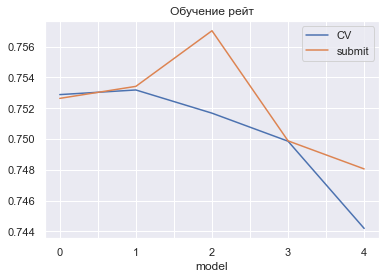

In [38]:
models = [f'{i}' for i in range(len(cvLearningRates))]

df = pd.DataFrame(list(zip(models, cvLearningRates, subLearningRates)), columns=['model', 'CV', 'submit'])

ax = df.plot(x='model', y=['CV', 'submit'])
ax.set_title("Обучение рейт")

depth:

Text(0.5, 1.0, 'depths')

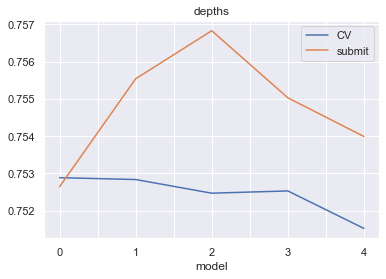

In [39]:
models = [f'{i}' for i in range(len(cvDepths))]

df = pd.DataFrame(list(zip(models, cvDepths, subDepths)), columns=['model', 'CV', 'submit'])

ax = df.plot(x='model', y=['CV', 'submit'])
ax.set_title("depths")

l2 coeff:

Text(0.5, 1.0, 'l2_leaf_reg')

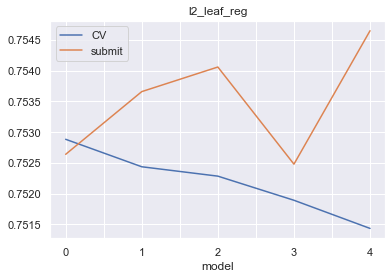

In [40]:
models = [f'{i}' for i in range(len(cvL2s))]

df = pd.DataFrame(list(zip(models, cvL2s, subL2s)), columns=['model', 'CV', 'submit'])

ax = df.plot(x='model', y=['CV', 'submit'])
ax.set_title("l2_leaf_reg")

### Выводы по пункту 0

1) Переобучение имело место быть при варьировании learning_rate и depth, но оно было не очень сильным и все равно можно увидеть оптимальное значение.

2) изменение параметра l2_leaf_reg не оказывает эффекта на результат. Изменение значений метрики больше похоже на погрешность

* возможно нужно было увеличить количество значений проверяемых

### 1) GridSearchCV и RandomizedSearchCV

grid search

In [41]:
model = CatBoostClassifier(iterations=100)

In [ ]:
grid = {
    'learning_rate': [0.2, 0.5, 0.7],
    'depth':[3, 6, 9],
    'l2_leaf_reg': [1, 2, 3]
}
grid_search_results = model.grid_search(grid, train[x_cols], train["TARGET"], shuffle=False, verbose=0, plot=True)

-> 99: learn: 0.2447161 test: 0.2475482	best: 0.2475482 (99)	total: 911ms	remaining: 0us

bestTest: 0.247548157
bestIteration: 99

In [44]:
grid_search_results['params']

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.5}

randomized search

In [45]:
model = CatBoostClassifier(iterations=100)

In [ ]:
param_distribution = {
    'learning_rate': stats.uniform(0.3, 0.8),
    'depth': stats.bernoulli(p=0.2, loc=10),
    'l2_leaf_reg': stats.binom(n=2, p=0.2)
}

randomized_search_results = model.randomized_search(
    param_distribution,
    train[x_cols], train["TARGET"],
    n_iter=4,
    shuffle=False,
    search_by_train_test_split=False,
    verbose=0,
    plot=True
)

bestIteration = 15

Training on fold [0/3]

-> 0:	learn: 0.2618995	test: 0.2638176	best: 0.2638176 (0)	total: 50.4ms	remaining: 4.99s

-> 1:	learn: 0.2522402	test: 0.2586217	best: 0.2586217 (1)	total: 107ms	remaining: 5.24s

learning rate is greater than 1. You probably need to decrease learning rate.

learning rate is greater than 1. You probably need to decrease learning rate.



99:	learn: 0.1868161	test: 6395812442601980.0000000	best: 0.2574245 (9)	total: 2.66s	remaining: 0us

bestTest = 0.2574244936
bestIteration = 9

In [47]:
randomized_search_results['params']

{'depth': 10.0, 'learning_rate': 0.3013830452079781, 'l2_leaf_reg': 1.0}

### Выводы по пункту 1

1) Грид серч: {'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.5}

2) Рандомайзд серч: {'depth': 10.0, 'l2_leaf_reg': 1.0, 'learning_rate': 0.3013830452079781}

### 2) Feature importance

In [48]:
train_pool = Pool(train[x_cols], train["TARGET"])

In [49]:
model = CatBoostClassifier(**randomized_search_results['params'],
                iterations=1, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = x_cols

Text(0.5, 1.0, 'feature_importance')

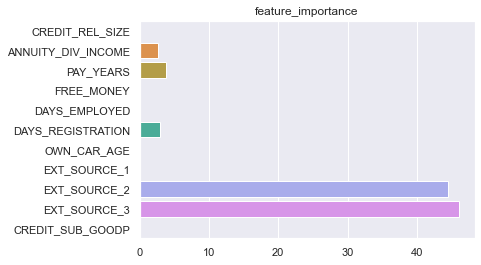

In [51]:
ax = sns.barplot(x=feature_importances, y=feature_names)
ax.set_title("feature_importance")

### Выводы по пункту 2

1) ANNUITY_DIV_INCOME, DAYS_REGISTRATION, PAY_YEARS, EXT_2, EXT_3 - в порядке возрастания значимости